In [ ]:
! pip -q install pandas matplotlib
! pip install -q scikit-learn
! pip install -q joblib
! pip install -q tensorflow

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])

In [ ]:
# Lets quickly examine what we work with:
print(train_df_raw.head(10))
print("\n***********************Closed*Warehouses*Data***********************************\n")
print(train_calendar_df_raw.head(10))

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [ ]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [ ]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df = merge_csv(train_df_raw, train_calendar_df_raw)
train_df.head()

### Drop unnecesary data

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [ ]:
unavailable_features = [
    'shutdown', 'mini_shutdown', 'blackout', 'mov_change',
    'frankfurt_shutdown', 'precipitation', 'snow', 
    'user_activity_1', 'user_activity_2', 
]

In [ ]:
train_df = train_df.drop(columns=unavailable_features)
train_df = train_df.drop(columns=['id']) # redundant

In [ ]:
# list redundant columns
unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
unchanging_columns

train_df = train_df.drop(columns=unchanging_columns)

In [ ]:
train_df.head()

In [ ]:
print(f"Original warehouses: {train_df.warehouse.unique()}")

In [ ]:
whs = train_df.groupby('warehouse')['orders'].sum()

plt.bar(whs.index, whs.values)
plt.xlabel('Warehouse')
plt.ylabel('Number of records')
plt.title('Number of records per warehouse')
plt.show()

### Compare feature Colerations

In [ ]:
train_df_corr = train_df.drop(columns=['warehouse', 'holiday_name']).corr()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### OH encoding of categorical features

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import joblib

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit the encoder on 'warehouse' and 'holiday_name' columns
encoded_features = encoder.fit_transform(train_df[['warehouse', 'holiday_name']])

# Get the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(['warehouse', 'holiday_name'])


# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

#print(encoded_df.head())
encoded_df = encoded_df.drop(columns=['holiday_name_nan'])

# Concatenate the encoded features with the original DataFrame
#train_df = pd.concat([train_df.drop(columns=['warehouse', 'holiday_name']), encoded_df], axis=1)
train_df = pd.concat([train_df, encoded_df], axis=1)

# Save the encoder
joblib.dump(encoder, 'scaler_onehot_categorical.joblib')

### Process the Data

In [ ]:
def process_date(df):
    df.index = df.pop('date')
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

In [ ]:
process_date(train_df)
train_df.head()

In [ ]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

In [ ]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

### Min-Max scale numerical features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Identify numerical columns to scale
numerical_cols = ['orders']
date_cols = ['year', 'month', 'day', 'day_of_week']

# Initialize the scaler
num_scaler = MinMaxScaler()
date_scaler = MinMaxScaler()

# Fit the scaler on the numerical columns
train_df[numerical_cols] = num_scaler.fit_transform(train_df[numerical_cols])
train_df[date_cols] = date_scaler.fit_transform(train_df[date_cols])

# Save the scaler
joblib.dump(num_scaler, 'scaler_minmax_numerical.joblib')
joblib.dump(date_scaler, 'scaler_minmax_date.joblib')

In [ ]:
train_df.describe()

### Load Dataset

In [ ]:
X = train_df.drop(columns=['orders', 'warehouse', 'holiday_name']) # Drop the target column and categorical columns
y = train_df['orders']  # Target column

In [ ]:
X.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
# Reshape data for LSTM [samples, timesteps, features]
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))

X_train_lstm.shape

### Compile and Fit the model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional


model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.3))

# Second LSTM layer with dropout
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.3))

# Optional: Add a GRU layer
model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer with dropout
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))

# Dense output layer
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_val_lstm, y_val))


In [ ]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save('model_lstm.h5')

## Inference

In [1]:
import pandas as pd
import joblib

dataframe = pd.read_csv("data/test.csv")
train_df_raw = pd.read_csv("data/train.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])

In [2]:
loaded_oh_encoder = joblib.load('scaler_onehot_categorical.joblib')
loaded_num_scaler = joblib.load('scaler_minmax_numerical.joblib')
loaded_date_scaler = joblib.load('scaler_minmax_date.joblib')

In [3]:
from working import preprocess_data

categorical_columns = ['warehouse', 'holiday_name']
numerical_columns = None
date_columns = ['year', 'month', 'day', 'day_of_week']

processed_data = preprocess_data(dataframe, categorical_columns, numerical_columns, date_columns, loaded_oh_encoder, loaded_num_scaler, loaded_date_scaler)

In [4]:
processed_data = processed_data.drop(columns=['id'])
processed_data.head()     

,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,...,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day,year,month,day,day_of_week,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2024-03-16,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.500000,0.833333,1
2024-03-17,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.533333,1.000000,1
2024-03-18,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.566667,0.000000,0
2024-03-19,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.600000,0.166667,0
2024-03-20,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.633333,0.333333,0


In [5]:
processed_data.shape

(397, 40)

In [6]:
# Compare the columns in the original and processed dataframes

X_columns = set(X.columns)
processed_data_columns = set(processed_data.columns)

if X_columns == processed_data_columns:
    print("Both dataframes have the same columns.")
else:
    print("The dataframes have different columns.")

    columns_only_in_X = X_columns - processed_data_columns
    columns_only_in_processed_data = processed_data_columns - X_columns

    if columns_only_in_X:
        print("Columns present only in X:")
        print(columns_only_in_X)

    if columns_only_in_processed_data:
        print("Columns present only in processed_data:")
        print(columns_only_in_processed_data)

NameError: name 'X' is not defined

In [6]:
import tensorflow as tf

# Load the trained model and make predictions on processed data:
model = tf.keras.models.load_model('model_lstm.h5')
processed_data_lstm = processed_data.values.reshape((processed_data.shape[0], 1, processed_data.shape[1]))
predictions = model.predict(processed_data_lstm)

13/13 [==============================] - 2s 5ms/step


In [11]:
# Rescale the predictions to original scale:
predictions_rescaled = loaded_num_scaler.inverse_transform(predictions)
submission_df_rescaled = pd.DataFrame({'id': dataframe['id'], 'orders': predictions_rescaled.flatten()})
submission_df_rescaled.to_csv('submission_rescaled.csv', index=False)
submission_df_rescaled.head()

,id,orders
0,Prague_1_2024-03-16,9287.474609
1,Prague_1_2024-03-17,9485.530273
2,Prague_1_2024-03-18,9111.381836
3,Prague_1_2024-03-19,9320.732422
4,Prague_1_2024-03-20,9539.498047


In [8]:
# Add the date column as an index and warehouse column to the rescaled predictions 
submission_df_rescaled['date'] = dataframe['date']
submission_df_rescaled['warehouse'] = dataframe['warehouse']
submission_df_rescaled.head()

,id,orders,date,warehouse
0,Prague_1_2024-03-16,-0.045508,2024-03-16,Prague_1
1,Prague_1_2024-03-17,-0.045507,2024-03-17,Prague_1
2,Prague_1_2024-03-18,-0.045508,2024-03-18,Prague_1
3,Prague_1_2024-03-19,-0.045507,2024-03-19,Prague_1
4,Prague_1_2024-03-20,-0.045507,2024-03-20,Prague_1


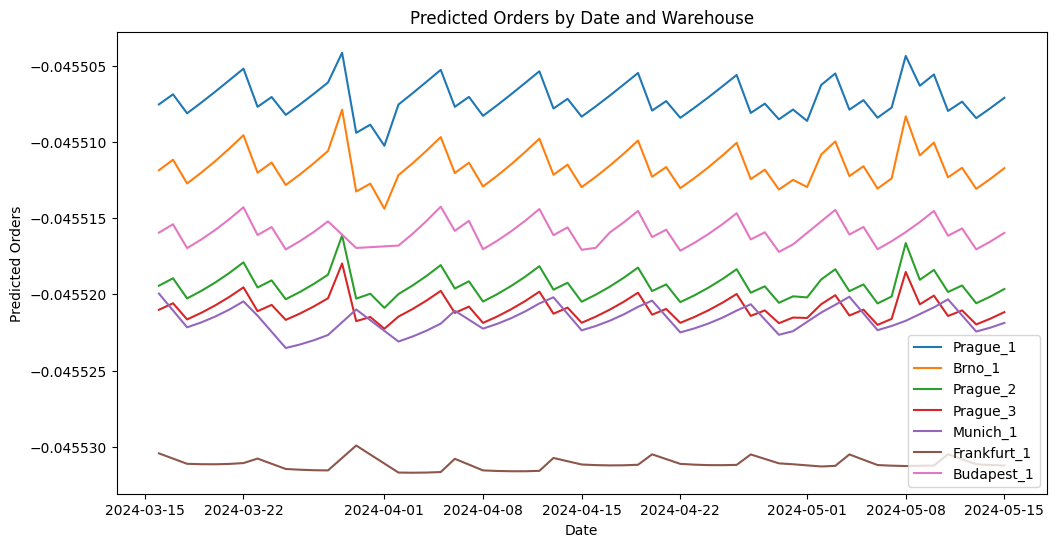

In [9]:
import matplotlib.pyplot as plt
# Visualise rescaled predictions with date for every warehouse on the same plot
warehouses = submission_df_rescaled['warehouse'].unique()
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df_rescaled[submission_df_rescaled['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=wh)
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()

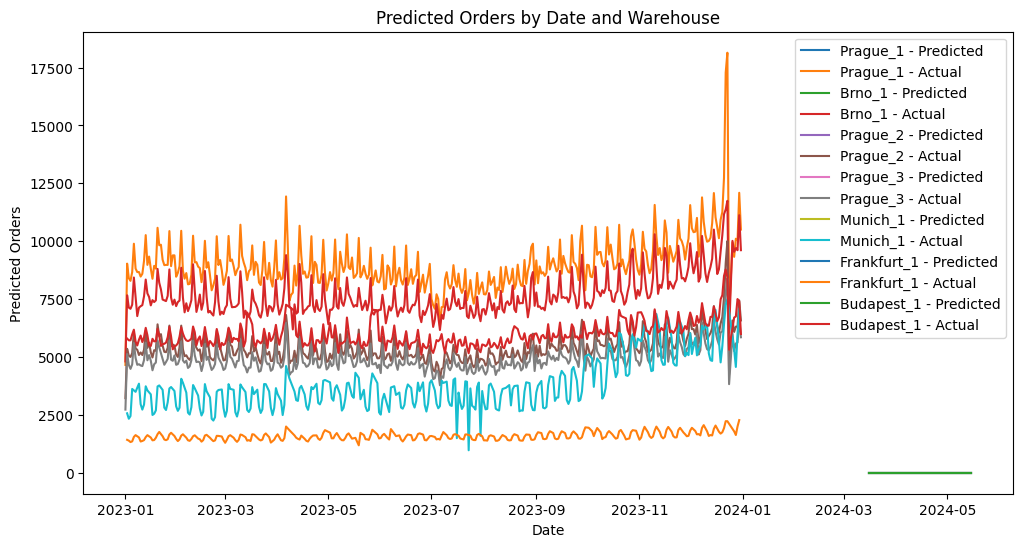

In [10]:
# Visualise the predictions in compare to the same dates in the training data in year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year == 2023]
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df_rescaled[submission_df_rescaled['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=f'{wh} - Predicted')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label=f'{wh} - Actual')
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming these dataframes are already loaded
# train_df_raw: Raw training data
# submission_df_rescaled: Rescaled predictions
# warehouses: List of warehouse names

# Filter training data for the year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year == 2023]

# Create separate plots for each warehouse
for wh in warehouses:
    wh_df = submission_df_rescaled[submission_df_rescaled['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    
    plt.figure(figsize=(12, 6))
    plt.plot(wh_df['date'], wh_df['orders'], label='Predicted', linestyle='--', color='r')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label='Actual', color='b')
    plt.title(f'Predicted vs Actual Orders for {wh} in 2023')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()


NameError: name 'warehouses' is not defined